<h1 style="color:red; text-align:center; font-weight:bold"> Sentiment Analysis </h1>

First we will install the `findspark` package, which is a Python library that helps to locate the __Apache Spark__ installation on a _local machine_. 

When `findspark` is installed, it adds the necessary environment variables to the current Python session, so that Spark can be easily accessed and used from within a Python script or notebook. This makes it easier to work with Spark without having to configure environment variables manually.

In [10]:
# pip install findspark

<h3 style="color:green"> Prepare the environment: </h3>

Now, we should search for the Spark installation directory and sets the required environment variables like __SPARK_HOME__ and __PYSPARK_PYTHON__ (path to the Python executable), which are needed for running Spark applications from a Python environment.

By running `findspark.init()` in a Python script or notebook, it makes it possible to use the PySpark API, which is the Python API for Spark, and access Spark's distributed computing capabilities from within your Python environment.

In [11]:
import findspark
findspark.init()

Let's import modules and classes from the PySpark library and creates a SparkSession object. 

In [12]:
import matplotlib.pyplot as plt
from tabulate import tabulate

from pyspark.sql import SparkSession

from pyspark.sql.functions import lit
from pyspark.sql.functions import rand
from pyspark.sql.functions import regexp_replace

from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

Initializing the ANSI escape codes to color the output in case of need

In [13]:
# Color code constants
COLOR_RED = "\u001b[38;5;124m"
COLOR_MAGENTA = "\033[95m"
COLOR_RESET = "\033[0m"

Initializing the data paths

In [14]:
train_pos_path = "aclImdb/train/pos/"
train_neg_path = "aclImdb/train/neg/"
test_pos_path = "aclImdb/test/pos/"
test_neg_path = "aclImdb/test/neg/"

Data folder hierarchy

```shell
.
├── aclImdb
    ├── train
    |   ├── pos
    |   |   ├── 0_9.txt
    |   |   ├── 23_7.txt
    |   |   └── ...
    |   └── neg
    |       ├── 0_3.txt 
    |       ├── 10_2.txt
    |       └── ...
    └── test
        ├── pos
        |   ├── 30_9.txt
        |   ├── 24_10.txt
        |   └── ...
        └── neg
            ├── 6_3.txt
            ├── 25_3.txt
            └── ...

Creates a SparkSession object named spark with the name "Project 1"

In [15]:
spark = SparkSession.builder.appName("Project 1").getOrCreate()

Creates a Tokenizer object named tokenizer with the input column named "value" and the output column named "words". 
Creates a StopWordsRemover object named swr with the input column set to the output column of the tokenizer object and the output column named "MeaningfulWords".

In [16]:
tokenizer = Tokenizer(inputCol="value", outputCol="words")

swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="MeaningfulWords")

<h3 style="color:green"> Import Data: </h3>

Let's read all the text files containing __positive__ movie reviews, for that we will create a `Spark DataFrame` with two columns:
 - "`value`" containing the text of each review
 - "`label`" indicating whether the review is positive or negative. 
 
In this case, the "__label__" column is set to __1__ for all rows since these are positive reviews.

In [17]:
pos_reviews = spark.read.option("wholeTextFiles", "true").text(train_pos_path)

pos_reviews = pos_reviews.withColumn("label", lit(1))

Let's take a look on the basic information about the `pos_reviews` DataFrame: data type, column names, and number of rows...

In [18]:
print(f"The type of {COLOR_RED}pos_reviews{COLOR_RESET} is: {type(pos_reviews)}")
print(f"Columns of the {COLOR_RED}pos_reviews{COLOR_RESET} dataframe are: {pos_reviews.columns}")
print(f"The number of rows in {COLOR_RED}pos_reviews{COLOR_RESET} is: {pos_reviews.count()}")

premiere_ligne = pos_reviews.first()
print(f"The first row of the {COLOR_RED}pos_reviews{COLOR_RESET} dataframe is:")
print(f"  {COLOR_MAGENTA}value{COLOR_RESET}: {premiere_ligne['value']}")
print(f"  {COLOR_MAGENTA}label{COLOR_RESET}: {premiere_ligne['label']}")

The type of pos_reviews is: <class 'pyspark.sql.dataframe.DataFrame'>
Columns of the pos_reviews dataframe are: ['value', 'label']


The number of rows in pos_reviews is: 12500
The first row of the pos_reviews dataframe is:
  value: Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then 

We'll do the some thing with the negative reviews, we'll read all the text files containing __negative__ movie reviews, and set the "__label__" column to __0__ for all rows.

In [19]:
neg_reviews = spark.read.option("wholeTextFiles", "true").text(train_neg_path)

neg_reviews = neg_reviews.withColumn("label", lit(0))

In [20]:
print(f"The type of {COLOR_RED}neg_reviews{COLOR_RESET} is: {type(neg_reviews)}")
print(f"Columns of the {COLOR_RED}neg_reviews{COLOR_RESET} dataframe are: {neg_reviews.columns}")
print(f"The number of rows in {COLOR_RED}neg_reviews{COLOR_RESET} is: {neg_reviews.count()}")

premiere_ligne = neg_reviews.first()
print(f"The first row of the {COLOR_RED}neg_reviews{COLOR_RESET} dataframe is:")
print(f"  {COLOR_MAGENTA}value{COLOR_RESET}: {premiere_ligne['value']}")
print(f"  {COLOR_MAGENTA}label{COLOR_RESET}: {premiere_ligne['label']}")

The type of neg_reviews is: <class 'pyspark.sql.dataframe.DataFrame'>
Columns of the neg_reviews dataframe are: ['value', 'label']
The number of rows in neg_reviews is: 12500
The first row of the neg_reviews dataframe is:
  value: Some have praised _Atlantis:_The_Lost_Empire_ as a Disney adventure for adults. I don't think so--at least not for thinking adults.<br /><br />This script suggests a beginning as a live-action movie, that struck someone as the type of crap you cannot sell to adults anymore. The "crack staff" of many older adventure movies has been done well before, (think _The Dirty Dozen_) but _Atlantis_ represents one of the worse films in that motif. The characters are weak. Even the background that each member trots out seems stock and awkward at best. An MD/Medicine Man, a tomboy mechanic whose father always wanted sons, if we have not at least seen these before, we have seen mix-and-match quirks before. The story about how one companion, Vinny played by Don Novello (Fr.

We need the data in one DataFrame, for that we'll concatenate the positive and negative movie review DataFrames (`pos_reviews` and `neg_reviews`, respectively) into a single DataFrame called `train_reviews`. This is done using the `union` method, which combines the rows of two DataFrames while preserving the column structure. 

The resulting `train_reviews` DataFrame contains all of the movie reviews (both positive and negative) and their corresponding labels.

In [21]:
train_reviews = pos_reviews.union(neg_reviews)

In [22]:
print(f"Le DataFrame {COLOR_RED}train_reviews{COLOR_RESET} contient {train_reviews.count()} lignes")

distinct_labels = train_reviews.select("label").distinct()
label_list = [row["label"] for row in distinct_labels.collect()]
print(f"\nDistinct label values in {COLOR_RED}train_reviews{COLOR_RESET}: {label_list}")

print(f"\nThe first 10 rows of the {COLOR_RED}train_reviews{COLOR_RESET} are:")
print(train_reviews.show(10))

print(f"\nThe last 10 rows of the {COLOR_RED}train_reviews{COLOR_RESET} are:")
tail_table = tabulate(train_reviews.tail(10), headers=train_reviews.columns, tablefmt="psql")
print(tail_table)

Le DataFrame train_reviews contient 25000 lignes

Distinct label values in train_reviews: [1, 0]

The first 10 rows of the train_reviews are:
+--------------------+-----+
|               value|label|
+--------------------+-----+
|Match 1: Tag Team...|    1|
|**Attention Spoil...|    1|
|Titanic directed ...|    1|
|By now you've pro...|    1|
|*!!- SPOILERS - !...|    1|
|Warning: Does con...|    1|
|Polish film maker...|    1|
|Berlin-born in 19...|    1|
|I thought that RO...|    1|
|CitizenX(1995) is...|    1|
+--------------------+-----+
only showing top 10 rows

None

The last 10 rows of the train_reviews are:
+----------------------------------------------------------------------------------------------------------------------+---------+
| value                                                                                                                |   label |
|------------------------------------------------------------------------------------------------------------------

To shuffle the rows of `train_reviews` DataFrame we'll use the `orderBy()` method with the `rand()` function as the argument. This randomizes the order of the rows in the DataFrame.

In [23]:
train_reviews_shuffled = train_reviews.orderBy(rand())

print(f"The first 10 rows of the {COLOR_RED}train_reviews_shuffled{COLOR_RESET} are:")
print(train_reviews_shuffled.show(10))

The first 10 rows of the train_reviews_shuffled are:
+--------------------+-----+
|               value|label|
+--------------------+-----+
|I happened across...|    1|
|A tour deforce! O...|    1|
|Spanish films are...|    1|
|What the heck was...|    0|
|I only watched th...|    0|
|I had read a few ...|    0|
|This is the crapp...|    0|
|This movie is not...|    0|
|Hood of the Livin...|    0|
|Boston legal has ...|    0|
+--------------------+-----+
only showing top 10 rows

None


Visualizing the `label` column:

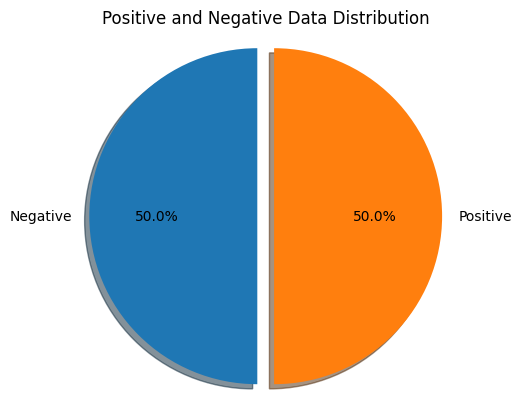

In [24]:
aggregated_data = train_reviews_shuffled.groupBy("label").count().toPandas()

total_count = aggregated_data["count"].sum()
aggregated_data["percentage"] = aggregated_data["count"] / total_count * 100

labels = ["Negative", "Positive"]
sizes = aggregated_data["percentage"]
explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.axis('equal') 

plt.title("Positive and Negative Data Distribution")
plt.show()

<h3 style="color:green"> Preprocess the Data: </h3>

Now we move to prepocessing step. First, we'll remove any _HTML tags_ from the `value` column using the `regexp_replace` function from the `pyspark.sql.functions` module. Then, we'll remove any _non-alphabetic characters_ (such as punctuation marks) from the `value` column using the same function. 

Then we'll use the `transform` method from the `Tokenizer` and `StopWordsRemover` classes to tokenize and remove stop words from the `value` column. The transformed DataFrame will store in the `tokenizedTrain` variable.

In [25]:
train_reviews_shuffled = train_reviews_shuffled.withColumn("value", regexp_replace("value", "<.*?>", ""))
train_reviews_shuffled = train_reviews_shuffled.withColumn("value", regexp_replace("value", "[^a-zA-Z\\s]", ""))

tokenizedTrain = tokenizer.transform(train_reviews_shuffled)
tokenizedTrain = swr.transform(tokenizedTrain)

tokenizedTrain.show(n=5)

+--------------------+-----+--------------------+--------------------+
|               value|label|               words|     MeaningfulWords|
+--------------------+-----+--------------------+--------------------+
|I happened across...|    1|[i, happened, acr...|[happened, across...|
|A tour deforce OK...|    1|[a, tour, deforce...|[tour, deforce, o...|
|Spanish films are...|    1|[spanish, films, ...|[spanish, films, ...|
|What the heck was...|    0|[what, the, heck,...|[heck, somebody, ...|
|I only watched th...|    0|[i, only, watched...|[watched, first, ...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



Let's ensure theat the stopwords has been removed by counting the size of `words` and `MeaningfulWords` columns of the 1st row.

In [26]:
p1=tokenizedTrain.select(size("words")).first()[0]
p2=tokenizedTrain.select(size("MeaningfulWords")).first()[0]
print(f"Number of words in {COLOR_RED}words{COLOR_RESET} column is: {p1}")
print(f"Number of words in {COLOR_RED}MeaningfulWords{COLOR_RESET} column is: {p2}")

Number of words in words column is: 185
Number of words in MeaningfulWords column is: 102


This next code creates a `HashingTF` transformer, which takes the `MeaningfulWords` column from `tokenizedTrain` as input and creates a new column called `features` containing a _vector_ of hashed word frequencies. 

The transformed data is stored in `numericTrainData`, which is a DataFrame with additional columns `features` and `rawPrediction` containing the hashed word frequency vectors and model predictions, respectively.

In [27]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(tokenizedTrain)

numericTrainData.show(n=5)

+--------------------+-----+--------------------+--------------------+--------------------+
|               value|label|               words|     MeaningfulWords|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|I happened across...|    1|[i, happened, acr...|[happened, across...|(262144,[1004,157...|
|A tour deforce OK...|    1|[a, tour, deforce...|[tour, deforce, o...|(262144,[3121,455...|
|Spanish films are...|    1|[spanish, films, ...|[spanish, films, ...|(262144,[6034,626...|
|What the heck was...|    0|[what, the, heck,...|[heck, somebody, ...|(262144,[511,2751...|
|I only watched th...|    0|[i, only, watched...|[watched, first, ...|(262144,[1696,978...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



<h3 style="color:green"> Modeling </h3>

For this case, we'll use the logistic regression model and the SVM model. 



#### LOGISTIC REGRESSION

The logistic regression model is instantiated with the label column specified as `labelCol="label"`, the features column specified as `featuresCol="features"`, the maximum number of iterations to run specified as `maxIter=10`, and the regularization parameter specified as `regParam=0.01`.

In [28]:
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model_lr = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


To test this model we'll use new data; first we should import this data, we'll do the same steps as train data. The test data we'll be stored in `test_reviews` DataFrame.

In [29]:
pos_reviews_test = spark.read.option("wholeTextFiles", "true").text(test_pos_path)

pos_reviews_test = pos_reviews_test.withColumn("label", lit(1))

In [30]:
neg_reviews_test = spark.read.option("wholeTextFiles", "true").text(test_neg_path)

neg_reviews_test = neg_reviews_test.withColumn("label", lit(0))

In [31]:
test_reviews = pos_reviews_test.union(neg_reviews_test)

print(f"Le DataFrame {COLOR_RED}test_reviews{COLOR_RESET} contient {test_reviews.count()} lignes")

distinct_labels = test_reviews.select("label").distinct()
label_list = [row["label"] for row in distinct_labels.collect()]
print(f"\nDistinct label values in {COLOR_RED}test_reviews{COLOR_RESET}: {label_list}")

print(f"\nThe first 10 rows of the {COLOR_RED}test_reviews{COLOR_RESET} are:")
print(test_reviews.show(10))

print(f"\nThe last 10 rows of the {COLOR_RED}test_reviews{COLOR_RESET} are:")
tail_table = tabulate(test_reviews.tail(10), headers=train_reviews.columns, tablefmt="psql")
print(tail_table)


Le DataFrame test_reviews contient 25000 lignes

Distinct label values in test_reviews: [1, 0]

The first 10 rows of the test_reviews are:
+--------------------+-----+
|               value|label|
+--------------------+-----+
|There's a sign on...|    1|
|(Some spoilers in...|    1|
|Back in the mid/l...|    1|
|If anyone ever as...|    1|
|Films belonging t...|    1|
|The Merchant of V...|    1|
|'The Merchant of ...|    1|
|The silent film m...|    1|
|Without question,...|    1|
|"The belief in th...|    1|
+--------------------+-----+
only showing top 10 rows

None

The last 10 rows of the test_reviews are:
+-----------------------------------------------------------------------------------------------------------------------------------+---------+
| value                                                                                                                             |   label |
|--------------------------------------------------------------------------------------------

Shuffle the data of `neg_reviews` DataFrame.

In [32]:
test_reviews_shuffled = test_reviews.orderBy(rand())

Remove the _HTML tags_ and  _non-alphabetic characters_ (such as punctuation marks) from the `value` column using the `regexp_replace` function from the `pyspark.sql.functions` module.

In [33]:
test_reviews_shuffled = test_reviews_shuffled.withColumn("value", regexp_replace("value", "<.*?>", ""))
test_reviews_shuffled = test_reviews_shuffled.withColumn("value", regexp_replace("value", "[^a-zA-Z\\s]", ""))

tokenizedTest = tokenizer.transform(test_reviews_shuffled)
tokenizedTest = swr.transform(tokenizedTest)

tokenizedTest.show(n=5)

+--------------------+-----+--------------------+--------------------+
|               value|label|               words|     MeaningfulWords|
+--------------------+-----+--------------------+--------------------+
|I cant believe th...|    0|[i, cant, believe...|[cant, believe, a...|
|I wasnt even born...|    1|[i, wasnt, even, ...|[wasnt, even, bor...|
|This film is bund...|    0|[this, film, is, ...|[film, bundled, a...|
|I was invited to ...|    0|[i, was, invited,...|[invited, early, ...|
|Believe me when I...|    1|[believe, me, whe...|[believe, say, sh...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



Vectorizing the data.

In [34]:
numericTestData = hashTF.transform(tokenizedTest)
numericTestData.show(n=5)

+--------------------+-----+--------------------+--------------------+--------------------+
|               value|label|               words|     MeaningfulWords|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|I cant believe th...|    0|[i, cant, believe...|[cant, believe, a...|(262144,[535,654,...|
|I wasnt even born...|    1|[i, wasnt, even, ...|[wasnt, even, bor...|(262144,[4333,538...|
|This film is bund...|    0|[this, film, is, ...|[film, bundled, a...|(262144,[1546,169...|
|I was invited to ...|    0|[i, was, invited,...|[invited, early, ...|(262144,[1546,243...|
|Believe me when I...|    1|[believe, me, whe...|[believe, say, sh...|(262144,[4214,880...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



Now we move to evaluate the performance of the model by computing the AUC on a separate test dataset.

First, we'll create a `BinaryClassificationEvaluator` object with the `rawPredictionCol` parameter set to "rawPrediction" and the `labelCol` parameter set to "label". Then, we use the trained model to make predictions on the preprocessed test dataset `numericTestData` and stores the predictions in the `predictions` dataframe. Finally, we compute the accuracy using the `evaluate` method of the evaluator object on the `predictions` dataframe.

In [35]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
predictions = model_lr.transform(numericTestData)

acc = evaluator.evaluate(predictions)
print("Accuraccy: %g" % acc)

Accuraccy: 0.906162


Well done! It seems that we have a good model with an `AUC` of 90%.

Now let's use another model, the SVM:

#### SVM

The label column is set as `labelCol="label"`, indicating that it refers to the column containing the class labels in the dataset. The features column is set as `featuresCol="features"`, specifying the column that holds the feature vectors used for classification. The maximum number of iterations is set to `maxIter=10`, determining the maximum number of iterations the algorithm will perform to converge to a solution

In [36]:
lsvc = LinearSVC(labelCol="label", featuresCol="features", maxIter=10, regParam=0.01)

model_svm = lsvc.fit(numericTrainData)

print("Done!")

Done!


Now we move to evaluate the performance of the model by computing the AUC on a separate test dataset.


In [37]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
predictions = model_svm.transform(numericTestData)

acc = evaluator.evaluate(predictions)
print("Accuracy: %g" % acc)

Accuracy: 0.85316


`0.85` for SVM and `0.90` for the logistique regression, both gives great results so we can work either with logReg, SVM, or concatenate them.

<h3 style="color:green"> Final Test <h3>

In [38]:
review1 ="I recently watched the film 'The Shawshank Redemption,' and I must say it is an absolute masterpiece. The storytelling is captivating, and the performances by the cast are outstanding. The character development is exceptional, and you can't help but become emotionally invested in their journeys. The cinematography beautifully captures the essence of the story, and the music perfectly complements the scenes. 'The Shawshank Redemption' is a thought-provoking and inspiring film that leaves a lasting impact. I highly recommend it to anyone looking for a brilliant cinematic experience."
data = [(review1,)]
df = spark.createDataFrame(data, ['value'])

review2 = "Terrible acting, poor script, and predictable plot. This movie was a complete waste of time. I couldn't wait for it to end. Save yourself the disappointment and skip this one."
new_row = (review2,)

# Convert new_row to RDD
rdd = spark.sparkContext.parallelize([new_row])

# Convert RDD to DataFrame
df_review_test = rdd.toDF(['value'])

df_review_test = df.union(df_review_test)

df_review_test.show()

+--------------------+
|               value|
+--------------------+
|I recently watche...|
|Terrible acting, ...|
+--------------------+



In [39]:
tokenizedreview = tokenizer.transform(df_review_test)
tokenizedreview = swr.transform(tokenizedreview)
numericTestreview = hashTF.transform(tokenizedreview)
numericTestreview.show()

+--------------------+--------------------+--------------------+--------------------+
|               value|               words|     MeaningfulWords|            features|
+--------------------+--------------------+--------------------+--------------------+
|I recently watche...|[i, recently, wat...|[recently, watche...|(262144,[2488,463...|
|Terrible acting, ...|[terrible, acting...|[terrible, acting...|(262144,[6767,752...|
+--------------------+--------------------+--------------------+--------------------+



Test with SVM

In [40]:
predictions = model_svm.transform(numericTestreview)

predicted_labels_svm = predictions.select("prediction")
predicted_labels_svm.show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
+----------+



Test with Logistic Regression

In [41]:
predictions = model_lr.transform(numericTestreview)

predicted_labels_lr = predictions.select("prediction")
predicted_labels_lr.show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
+----------+

